dict_keys(['__header__', '__version__', '__globals__', 'ch_ss', 'ch_ss_filt'])
EEG data shape: (6, 773956)


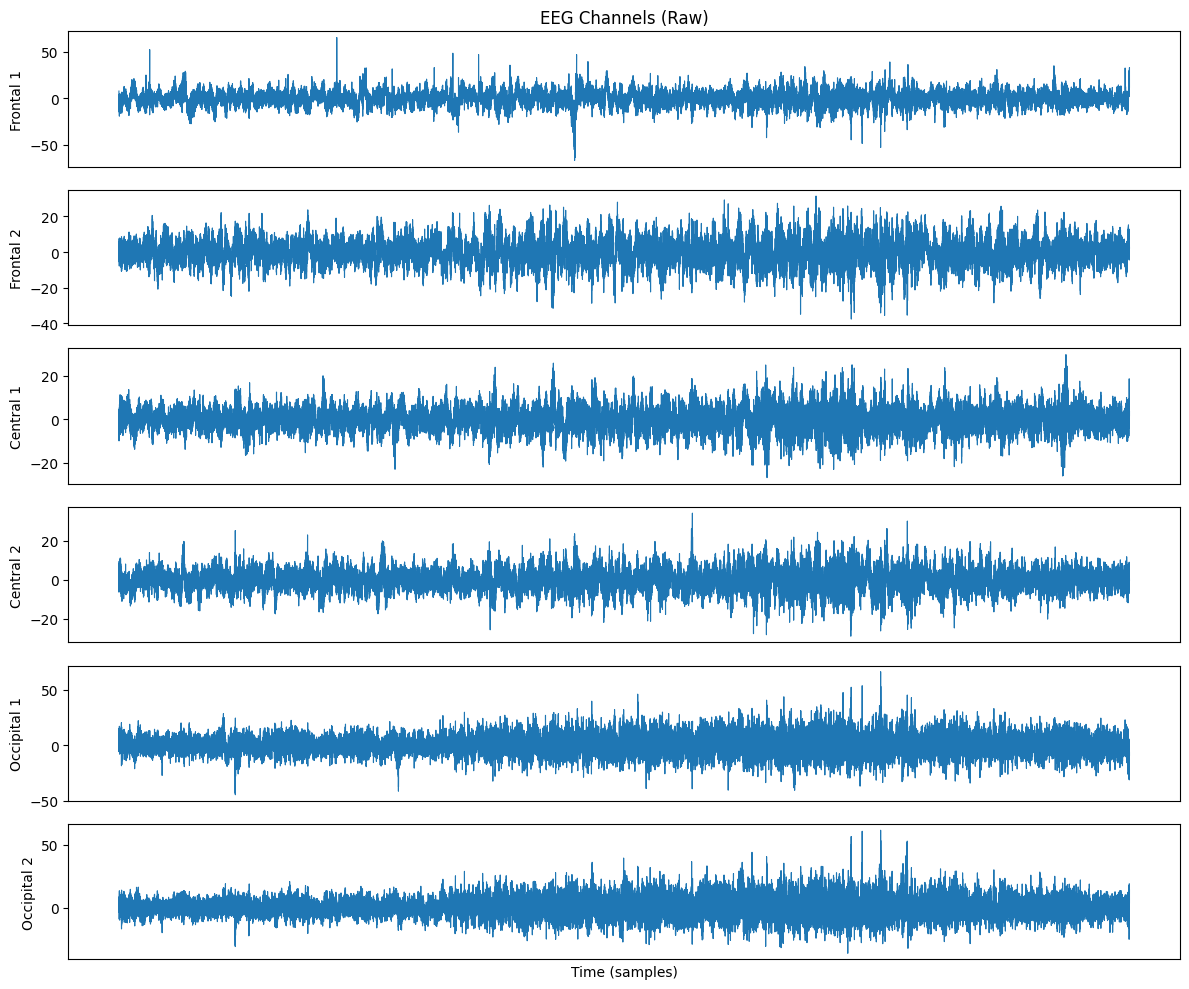

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Load the .mat file
mat = loadmat('run5_eeg_ss.mat')  # Replace with your filename
print(mat.keys())  # To inspect available keys

# Load EEG data assuming variable name is 'data'
eeg_data = mat['ch_ss_filt']  # Shape: [channels, samples]
print(f"EEG data shape: {eeg_data.shape}")

# Channel labels by group
channel_labels = [
    'Frontal 1', 'Frontal 2',
    'Central 1', 'Central 2',
    'Occipital 1', 'Occipital 2',
    'EOG 1', 'EOG 2',
    'EMG'
]

# Sanity check for number of channels
n_channels = eeg_data.shape[0]
if n_channels < 6:
    raise ValueError("Expected at least 9 EEG channels. Got only {}".format(n_channels))

# Plot all channels
plt.figure(figsize=(12, 10))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(eeg_data[i], linewidth=0.8)
    plt.ylabel(channel_labels[i])
    plt.xticks([])
    if i == 0:
        plt.title("EEG Channels (Raw)")
plt.xlabel("Time (samples)")
plt.tight_layout()
plt.show()


Creating RawArray with float64 data, n_channels=6, n_times=773956
    Range : 0 ... 773955 =      0.000 ...  1547.910 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=773956
    Range : 0 ... 773955 =      0.000 ...  1547.910 secs
Ready.


/Users/adiyarkm/Documents/GitHub/yasa/yasa-env/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adiyarkm/Documents/GitHub/yasa/yasa-env/lib/python3.9/site-packages/yasa/plotting.py:89: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  freq_str = pd.tseries.frequencies.to_offset(pd.Timedelta(1 / sf_hypno, "S")).freqstr


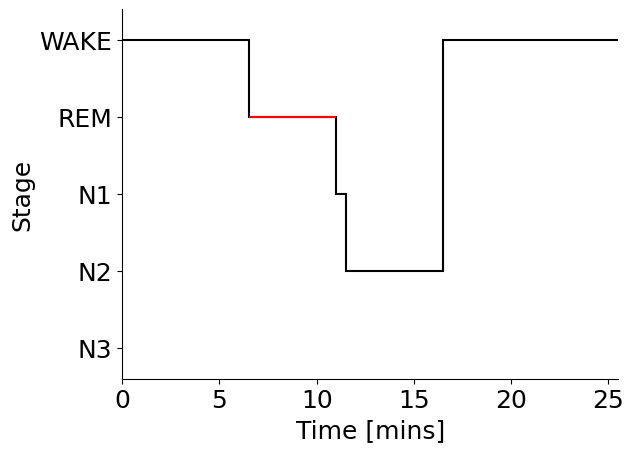

In [2]:
import pandas as pd
import numpy as np
import mne
import yasa  

# EEG settings
sf = 500  # Sampling frequency in Hz
channel_names = [
    'F1', 'F2', 'C3', 'C4', 'O1', 'O2'
]
channel_types = [
    'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg'
]

# Create MNE Raw object
info = mne.create_info(ch_names=channel_names, sfreq=sf, ch_types=channel_types)
raw = mne.io.RawArray(eeg_data, info)

# Averaging EEG channels 1:6 (F1 to O2)
eeg_channels = ['F1', 'F2', 'C3', 'C4', 'O1', 'O2']
avg_data = np.mean([raw.copy().pick(ch).get_data() for ch in eeg_channels], axis=0)

# Create a new Raw object with the averaged EEG channel
avg_info = mne.create_info(['EEG_avg'], sfreq=sf, ch_types='eeg')
raw_avg_chan = mne.io.RawArray(avg_data, avg_info)

# Use only the averaged channel for sleep staging
raw_avg = raw_avg_chan

# Run sleep staging using the average EEG data
sl = yasa.SleepStaging(raw_avg, eeg_name='EEG_avg', eog_name=None, emg_name=None)
hypno = sl.predict()
hypno_int = yasa.hypno_str_to_int(hypno)

# Plot hypnogram (1 epoch = 30 seconds)
yasa.plot_hypnogram(hypno_int, sf_hypno=1/30)

np.savetxt("hypnogram.txt", hypno_int, fmt='%d')

